20241003
PyTorch based DL CNN classification for Images - Good vs MacroBlocks

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import multiprocessing

In [2]:
class DynamicCNN(nn.Module):
    def __init__(self, input_size):
        super(DynamicCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        # Calculate the size of the feature maps after convolutions and pooling
        self.feature_size = self._get_conv_output(input_size)
        
        self.classifier = nn.Sequential(
            nn.Linear(self.feature_size, 64),
            nn.ReLU(),
            nn.Linear(64, 1),
            nn.Sigmoid()
        )

    def _get_conv_output(self, shape):
        batch_size = 1
        input = torch.autograd.Variable(torch.rand(batch_size, *shape))
        output_feat = self.features(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [3]:
class ImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = ['Good', 'MacroBlocks']
        self.image_paths = []
        self.labels = []

        for class_idx, class_name in enumerate(self.classes):
            class_dir = os.path.join(root_dir, class_name)
            if not os.path.exists(class_dir):
                print(f"Warning: Directory not found: {class_dir}")
                continue
            for item in os.listdir(class_dir):
                item_path = os.path.join(class_dir, item)
                if os.path.isfile(item_path) and item.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                    self.image_paths.append(item_path)
                    self.labels.append(class_idx)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

Epoch [1/10], Train Loss: 0.3488, Train Acc: 0.8719, Val Loss: 0.0231, Val Acc: 0.9938
Epoch [2/10], Train Loss: 0.0348, Train Acc: 0.9875, Val Loss: 0.0095, Val Acc: 1.0000
Epoch [3/10], Train Loss: 0.0263, Train Acc: 0.9906, Val Loss: 0.0208, Val Acc: 0.9876
Epoch [4/10], Train Loss: 0.0163, Train Acc: 0.9969, Val Loss: 0.0286, Val Acc: 0.9876
Epoch [5/10], Train Loss: 0.0496, Train Acc: 0.9891, Val Loss: 0.0276, Val Acc: 0.9876
Epoch [6/10], Train Loss: 0.0098, Train Acc: 0.9969, Val Loss: 0.0157, Val Acc: 0.9876
Epoch [7/10], Train Loss: 0.2678, Train Acc: 0.9750, Val Loss: 0.0097, Val Acc: 0.9938
Epoch [8/10], Train Loss: 0.0304, Train Acc: 0.9875, Val Loss: 0.0160, Val Acc: 0.9938
Epoch [9/10], Train Loss: 0.0069, Train Acc: 0.9969, Val Loss: 0.0116, Val Acc: 0.9938
Epoch [10/10], Train Loss: 0.0018, Train Acc: 1.0000, Val Loss: 0.0124, Val Acc: 0.9938
Training completed and model saved.
Test Loss: 0.0353, Test Accuracy: 0.9950


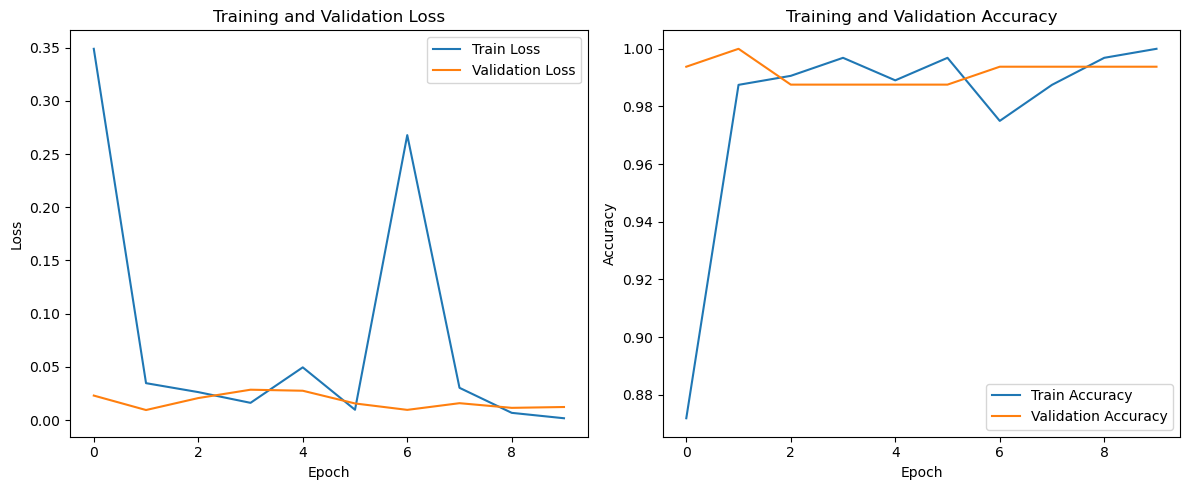

In [7]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def main():
    images_dir = r"C:\Manoj\__Project_Eti_TS AV Analyzer\Create Dataset\Images"

        

    # Get the size of the first image to determine input size
    def get_first_image_path(directory):
        for item in os.listdir(directory):
            item_path = os.path.join(directory, item)
            if os.path.isfile(item_path) and item.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
                return item_path
        return None

    good_folder = os.path.join(images_dir, 'Good')
    first_image_path = get_first_image_path(good_folder)

    if first_image_path is None:
        raise FileNotFoundError(f"No image files found in the 'Good' folder: {good_folder}")

    with Image.open(first_image_path) as img:
        original_size = img.size
        with Image.open(first_image_path) as img:
            original_size = img.size

    # Calculate new size (keeping aspect ratio, with max dimension 400)
    max_dim = 400
    scale = min(max_dim / original_size[0], max_dim / original_size[1])
    new_size = (int(original_size[0] * scale), int(original_size[1] * scale))

    # Set up data transforms
    transform = transforms.Compose([
        transforms.Resize(new_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])


    # Create datasets
    full_dataset = ImageDataset(root_dir=images_dir, transform=transform)
    
    # Split the dataset into train+val and test sets
    train_val_dataset, test_dataset = train_test_split(full_dataset, test_size=0.2, random_state=42)
    
    # Further split train+val into train and validation sets
    train_dataset, val_dataset = train_test_split(train_val_dataset, test_size=0.2, random_state=42)

    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=0)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=0)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=0)

    # Initialize the model, loss function, and optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DynamicCNN((3, new_size[1], new_size[0])).to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    num_epochs = 10
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    for epoch in range(num_epochs):
        model.train()
        train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        model.eval()
        val_loss, val_accuracy = evaluate(model, val_loader, criterion, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}')

    # Save the trained model
    torch.save(model.state_dict(), 'binary_classifier.pth')

    print("Training completed and model saved.")

    # Evaluate on test set
    test_loss, test_accuracy = evaluate(model, test_loader, criterion, device)
    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

    # Plot training and validation losses and accuracies
    plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies)

def train_epoch(model, dataloader, criterion, optimizer, device):
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.float().unsqueeze(1).to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def evaluate(model, dataloader, criterion, device):
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()

            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(dataloader)
    epoch_accuracy = correct / total
    return epoch_loss, epoch_accuracy

def plot_training_results(train_losses, val_losses, train_accuracies, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')

    plt.tight_layout()
    plt.savefig('training_plots.png')
    plt.show()

if __name__ == "__main__":
    main()


In [5]:
if __name__ == '__main__':
    multiprocessing.freeze_support()
    main()

Epoch [1/10], Loss: 0.3633
Epoch [2/10], Loss: 0.0463
Epoch [3/10], Loss: 0.0570
Epoch [4/10], Loss: 0.0177
Epoch [5/10], Loss: 0.0188
Epoch [6/10], Loss: 0.0091
Epoch [7/10], Loss: 0.0015
Epoch [8/10], Loss: 0.0004
Epoch [9/10], Loss: 0.0003
Epoch [10/10], Loss: 0.0002
Training completed and model saved.
